# COMPSCI 714 - Assignment 2

The goal of this assignment is to evaluate your ability to **implement, train and evaluate a specified CNN architecture** on a specific dataset, and make changes to improve the baseline performance.

In the first part of the assignment, you will need to implement the LeNet-5 CNN architecture and train it on the CIFAR-10 dataset. This will give you a baseline performance.

In the second part of the assignment, you will need to implement changes to improve this baseline.

**Name**: Hans Huang

**UPI**: hhua978 

**Student ID**: 221864541

## **Part 1: Implementing and evaluating the baseline** - 5 marks

For the first part of the assignment, you have to implement the LeNet-5 architecture (from [LeCun et al., 1998](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf)), and train it on the CIFAR10 dataset. 

![LeNet5 Architecture](image-5.png)

## Task 1.1: Load, prepare and split the data - 1 mark

For this assignment, you will use the CIFAR-10 dataset. It consists of 60000 32x32 colour images (RGB) divided in 10 mutually exclusive classes, with 6000 images per class. There are 50000 training images and 10000 test images. More information about the dataset (including the different classes with sample images) can be found at the following links.
- [Link to CIFAR-10 homepage](https://www.cs.toronto.edu/~kriz/cifar.html)
- [Link to the documentation on Paper With CodeLinks to an external site.](https://paperswithcode.com/dataset/cifar-10)

**Task deliverables**:
- Load the train and test datasets from `torchvision.datasets.CIFAR10`.
- Normalise the pixel values between 0 and 1.
- Split the train set in train and validation sets, with 80% of the data for training and 20% for validation.
- Create dataloaders with a batch size of 32. 

Notes:
- You can split the training set randomly, i.e., it is not required to handle any potential class imbalance for this task.

In [1]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

torch.manual_seed(42)
# Setup training data
train_data_full = datasets.CIFAR10(
            root="data",
            train=True,
            download=True,
            transform=ToTensor(), # convert to tensor and normalize between range 0 and 1
            target_transform=None
)

# Setup testing data
test_data = datasets.CIFAR10(
            root="data",
            train=False,
            download=True,
            transform=ToTensor()
)
print(f"Length of train data full: {len(train_data_full)}")
print(f"Length of test data: {len(test_data)}")

# Split train and valid data
train_size = int(0.8 * len(train_data_full))  
valid_size = len(train_data_full) - train_size  
train_data, valid_data = torch.utils.data.random_split(train_data_full, [train_size, valid_size])

# Create dataloader with batch size 32
BATCH_SIZE=32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Length of train data full: 50000
Length of test data: 10000


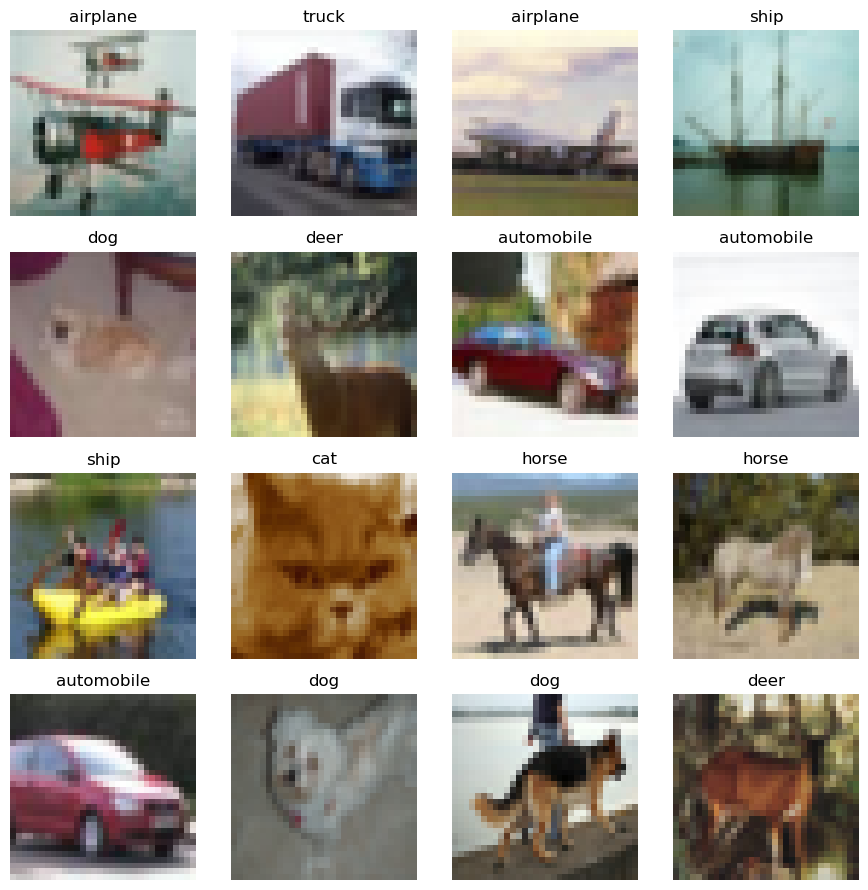

In [2]:
# Explore data 
import matplotlib.pyplot as plt
import torch

class_names = train_data_full.classes

# Plot more images
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data_full), size=[1]).item()
    img, label = train_data_full[random_idx]

    fig.add_subplot(rows, cols, i)

    # Convert image from [C, H, W] → [H, W, C]
    plt.imshow(img.permute(1, 2, 0))
    plt.title(class_names[label])
    plt.axis("off")

plt.tight_layout()
plt.show()


In [3]:
# Check out batch contents
print(f"Length of train dataloader: {len(train_loader)} batches of {BATCH_SIZE}")
print(f"Length of valid dataloader: {len(valid_loader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_loader)} batches of {BATCH_SIZE}")

Length of train dataloader: 1250 batches of 32
Length of valid dataloader: 313 batches of 32
Length of test dataloader: 313 batches of 32


## Task 1.2: Implementing and training the LeNet-5 model - 3 marks

The architecture you need to implement is specified as follows:

Layers: [5x5 Conv] -> [2x2 Pooling] -> [5x5 Conv] -> [2x2 Pooling] -> [FC 120] -> [FC 84] -> [FC 10]
The convolution layers have no stride (i.e., stride = 1) and valid padding.
The pooling layers use average pooling with no stride and valid padding.
All convolution layers and fully-connected layers have a ReLU activation (except the output layer).
The input image shape is 32x32x3 (RGB images).

**Task deliverables**:
- Define a model that implements the LeNet-5 architecture described above.
- Train the model using the following settings:
    - Optimiser: ADAM
    - Learning rate = 0.001
    - Loss: categorical crossentropy
    - Metric: accuracy
    - Epochs: 20
- Display the training and validation loss and accuracy curves.
- Compute and display the accuracy of the model on the test set.

Important notes: 
- It is recommended to use a Colab GPU runtime (or your own GPU if it is setup for it) to train the model.
- If using PyTorch, be mindful of the combination of output layer activation function and loss you use (see Lectutorial 3).

In [4]:
# Setup device agonistic code
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'mps'

In [5]:
import torch
import torch.nn as nn

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=0),  # Conv1
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=None, padding=0),                               # Pool1

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0), # Conv2
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=None, padding=0)                                # Pool2
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                       # Flatten
            nn.Linear(in_features=64*5*5, out_features=120),    # FC1
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),        # FC2
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)          # FC3 (Output layer, no activation)
        )

    def forward(self, x):
        x = self.feature(x)
        x = self.classifier(x)
        return x

model = LeNet5()

In [6]:
# Training function returning train and valid losses and evaluation metrics
def train(model, optimizer, loss_fn, eval_metric, train_loader, valid_loader, n_epochs):
    train_losses = []
    train_eval_metrics = []
    valid_losses = []
    valid_eval_metrics= []

    for epoch in range(n_epochs):

        #Training
        eval_metric.reset() # Reset the eval metric
        model.train()
        epoch_train_loss = 0.
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            y_train_pred = model(X_train_batch)
            train_loss = loss_fn(y_train_pred, y_train_batch)
            epoch_train_loss += train_loss.item()
            train_loss.backward()
            eval_metric.update(y_train_pred, y_train_batch) # Update eval metric for training
            optimizer.step()
            optimizer.zero_grad()
        mean_epoch_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(mean_epoch_train_loss)
        # Calculte and store training eval metric for this epoch
        epoch_training_eval_metric = eval_metric.compute().item()
        train_eval_metrics.append(epoch_training_eval_metric)

        # Model evaluation
        model.eval()
        eval_metric.reset() # Reset the eval metric
        epoch_valid_loss = 0.
        with torch.no_grad():
            for X_valid_batch, y_valid_batch in valid_loader:
                X_valid_batch, y_valid_batch = X_valid_batch.to(device), y_valid_batch.to(device)
                y_valid_pred = model(X_valid_batch)
                valid_loss = loss_fn(y_valid_pred, y_valid_batch)
                epoch_valid_loss += valid_loss.item()  # Update eval metric for validation
                eval_metric.update(y_valid_pred, y_valid_batch)
        mean_epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        valid_losses.append(mean_epoch_valid_loss)
        # Calculte and store validation eval metric for this epoch
        epoch_valid_eval_metric = eval_metric.compute().item()
        valid_eval_metrics.append(epoch_valid_eval_metric)

        print(f"Epoch {epoch + 1}/{n_epochs}, Training Loss: {mean_epoch_train_loss:.4f}, Valid Loss: {mean_epoch_valid_loss:.4f}")
        print(f"Epoch {epoch + 1}/{n_epochs}, Training Eval Metric: {epoch_training_eval_metric:.4f}, Valid Eval Metric: {epoch_valid_eval_metric:.4f}")

    return (train_losses, valid_losses, train_eval_metrics, valid_eval_metrics)

In [7]:
# Function to evaluate the model on the test set (evaluation metric only)
def evaluate_test_set(model, eval_metric, test_loader, metric_print):
    model.eval()
    eval_metric.reset() # Reset the eval metric
    test_loss = 0.
    with torch.no_grad():
      model.eval()
      eval_metric.reset() # Reset the eval metric
      total_test_loss = 0.
      with torch.no_grad():
          for X_test_batch, y_test_batch in test_loader:
              X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
              y_test_logits = model(X_test_batch)
              y_test_preds = torch.argmax(y_test_logits, dim=1)
              eval_metric.update(y_test_preds, y_test_batch)
      total_test_eval_metric = eval_metric.compute().item()

      print(f"Test {metric_print}: {total_test_eval_metric:.4f}")

In [8]:
# Define loss (cross entropy), evaluation metric (accuracy), optimiser, number of epochs, and launch the training
import torchmetrics
xentropy = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 20
model.to(device)
train_losses, valid_losses, train_accuracy, valid_accuracy = train(model, optimizer, xentropy, accuracy, train_loader, valid_loader, n_epochs)

Epoch 1/20, Training Loss: 1.7061, Valid Loss: 1.4514
Epoch 1/20, Training Eval Metric: 0.3712, Valid Eval Metric: 0.4753
Epoch 2/20, Training Loss: 1.3944, Valid Loss: 1.3062
Epoch 2/20, Training Eval Metric: 0.4984, Valid Eval Metric: 0.5276
Epoch 3/20, Training Loss: 1.2555, Valid Loss: 1.1967
Epoch 3/20, Training Eval Metric: 0.5512, Valid Eval Metric: 0.5718
Epoch 4/20, Training Loss: 1.1480, Valid Loss: 1.1281
Epoch 4/20, Training Eval Metric: 0.5929, Valid Eval Metric: 0.5923
Epoch 5/20, Training Loss: 1.0712, Valid Loss: 1.1490
Epoch 5/20, Training Eval Metric: 0.6217, Valid Eval Metric: 0.5973
Epoch 6/20, Training Loss: 1.0040, Valid Loss: 1.0664
Epoch 6/20, Training Eval Metric: 0.6445, Valid Eval Metric: 0.6211
Epoch 7/20, Training Loss: 0.9444, Valid Loss: 1.0341
Epoch 7/20, Training Eval Metric: 0.6653, Valid Eval Metric: 0.6365
Epoch 8/20, Training Loss: 0.8949, Valid Loss: 1.0038
Epoch 8/20, Training Eval Metric: 0.6836, Valid Eval Metric: 0.6443
Epoch 9/20, Training Los

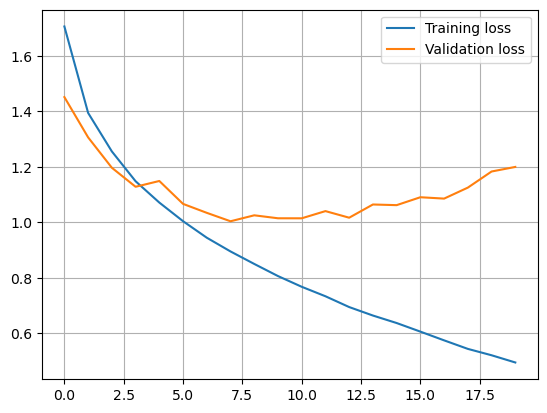

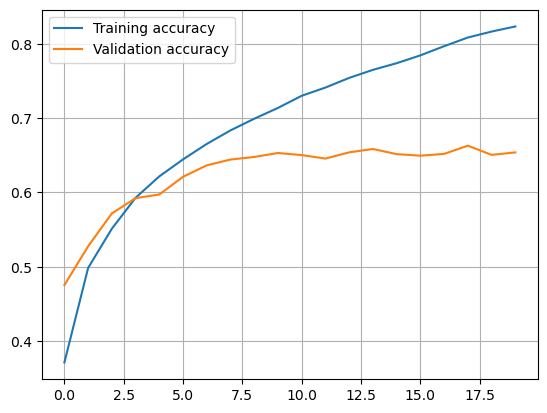

In [9]:
# Plot losses and accuracy
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.grid()
plt.legend()
plt.show()
plt.plot(train_accuracy, label='Training accuracy')
plt.plot(valid_accuracy, label='Validation accuracy')
plt.grid()
plt.legend()
plt.show()

In [10]:
# Evalutes the model on the test set
evaluate_test_set(model, accuracy, test_loader, "accuracy")

Test accuracy: 0.6514


## Task 1.3: Discuss the model's performance - 1 mark

**Task deliverable**:
- Discuss the model's perfomance using the architecture and training settings in Task 1.2 (100 words max). 

## Answers for task 1.3
Test accuracy is around 65%, which is not good enough, only slightly higher than purely guessing the results (50%). Increasing the number of epochs does not improve better performance, overfitting trend is observed. Below are potential causes and limitations for poor performance:
* Kernel size 5 without padding may reduce spatial resolution too quickly
* Too many training loops, causing the model to lose generalization ability
* Very shallow neural networks, only two layers for the conv block, which may be not sufficient
* Try different loss functions like SGD may improve the performance

# Part 2: Improve on the baseline - 5 marks

## Task 2.1: Improve the accuracy of the model - 2.5 marks

Starting from the LeNet-5 architecture you used in part 1, implement *at least* 3 changes to improve the performance of the model. For this task, the model's performance is primarily measured as the validation and test accuracy for the final model. 

**Task deliverables**: 
- Implement at least 3 changes in your model or the training process from Task 1, to improve the performance of the trained model.
- Show experimentally that your new model has a better performance than the baseline.
- 1 mark out of 2.5 is given for the level of accuracy of your improved model:
    - 1 mark if your model's test >= 70%.
    - 0.5 mark if your model's test accuracy is >= 60% and < 70%.
    - 0 mark if your model's test accuracy is < 60%.

*Notes*: 
- Each change should focus on different aspect of the model and/or training process. I.e., if change 1 is adding 1 extra convolution layer and change 2 is adding 2 extra convolution layers, they are not considered different change choices. Both are about adding more convolution layers in the network.
- You do not need to train a much deeper network to get a better performance. I.e., try to keep the training time reasonable to be able to experiment with several choices. 
- You can use what we covered in past tutorials, as well as your own research to make choices about what changes are likely to improve the model's performance.
- For this task, we use accuracy to evaluate the model's performance, but remember that a model's performance can include other criteria depending on the task and your goal (e.g., reduced overfitting, lesser training time with similar accuracy, better recall on imbalanced data, etc). 

## Please note: I have covered 10 different ways to improve model in order to see what is the best methods, changes have been highlighted in the comment line above each model. 

In [11]:
import torch
import torch.nn as nn
# Change out_channels to 64 for LeNet5V1 comparing to original model
class LeNet5V1(nn.Module):
    def __init__(self):
        super(LeNet5V1, self).__init__()

        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=None, padding=0),                               

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=None, padding=0)                                
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                       
            nn.Linear(in_features=128*5*5, out_features=120),    
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),        
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)        
        )

    def forward(self, x):
        x = self.feature(x)
        # print(f"output shape is: {x.shape}")
        x = self.classifier(x)
        return x

model = LeNet5V1()

In [12]:
# Comparing to LetNet5V1, LetNet5V2 changed kernel size for conv2d layer from 5 to 3
class LeNet5V2(nn.Module):
    def __init__(self):
        super(LeNet5V2, self).__init__()

        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=None, padding=0),                               

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=None, padding=0)                                
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                       
            nn.Linear(in_features=128*6*6, out_features=120),    
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),        
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)        
        )

    def forward(self, x):
        x = self.feature(x)
        # print(f"output shape is: {x.shape}")
        x = self.classifier(x)
        return x

model = LeNet5V2()

In [13]:
# Comparing to LetNet5V2, LetNet5V3 changed avgpool to maxpool
class LeNet5V3(nn.Module):
    def __init__(self):
        super(LeNet5V3, self).__init__()

        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=None, padding=0),                               

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=None, padding=0)                                
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                       
            nn.Linear(in_features=128*6*6, out_features=120),    
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),        
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)        
        )

    def forward(self, x):
        x = self.feature(x)
        # print(f"output shape is: {x.shape}")
        x = self.classifier(x)
        return x

model = LeNet5V3()

In [14]:
# Comparing to LetNet5V3, LetNet5V4 changed stride in MaxPool from none to 2
class LeNet5V4(nn.Module):
    def __init__(self):
        super(LeNet5V4, self).__init__()

        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                               

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)                                
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                       
            nn.Linear(in_features=128*6*6, out_features=120),    
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),        
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)        
        )

    def forward(self, x):
        x = self.feature(x)
        # print(f"output shape is: {x.shape}")
        x = self.classifier(x)
        return x

model = LeNet5V4()

In [15]:
# Comparing to LetNet5V4, LetNet5V5 added another BatchNorm Layer
class LeNet5V5(nn.Module):
    def __init__(self):
        super(LeNet5V5, self).__init__()

        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                               

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                       
            nn.Linear(in_features=128*6*6, out_features=120),    
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),        
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)
            
        )

    def forward(self, x):
        x = self.feature(x)
        # print(f"output shape is: {x.shape}")
        x = self.classifier(x)
        return x

model = LeNet5V5()

In [16]:
# Comparing to LetNet5V5, LetNet5V6 added new neurons, from 64 to 128 out_channels
class LeNet5V6(nn.Module):
    def __init__(self):
        super(LeNet5V6, self).__init__()

        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                               

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                       
            nn.Linear(in_features=128*6*6, out_features=120),    
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),        
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)
            
        )

    def forward(self, x):
        x = self.feature(x)
        # print(f"output shape is: {x.shape}")
        x = self.classifier(x)
        return x

model = LeNet5V6()

In [17]:
# Comparing to LetNet5V6, LetNet5V7 added new ConcBlock
class LeNet5V7(nn.Module):
    def __init__(self):
        super(LeNet5V7, self).__init__()

        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                               

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                       
            nn.Linear(in_features=256*2*2, out_features=120),    
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),        
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)
            
        )

    def forward(self, x):
        x = self.feature(x)
        # print(f"output shape is: {x.shape}")
        x = self.classifier(x)
        return x

model = LeNet5V7()

In [18]:
# Comparing to LetNet5V7, LetNet5V8 added new nn.Sequential out block
class LeNet5V8(nn.Module):
    def __init__(self):
        super(LeNet5V8, self).__init__()

        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                               

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                       
            nn.Linear(in_features=256*2*2, out_features=120),    
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),        
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=59),
            nn.ReLU(),
            nn.Linear(in_features=59, out_features=10)
            
        )

    def forward(self, x):
        x = self.feature(x)
        # print(f"output shape is: {x.shape}")
        x = self.classifier(x)
        return x

model = LeNet5V8()

In [19]:
# Comparing to LetNet5V8, LetNet5V9 added new dropout layers
class LeNet5V9(nn.Module):
    def __init__(self):
        super(LeNet5V9, self).__init__()

        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                               

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                       
            nn.Linear(in_features=256*2*2, out_features=120),    
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features=120, out_features=84),        
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features=84, out_features=59),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features=59, out_features=10)
            
        )

    def forward(self, x):
        x = self.feature(x)
        # print(f"output shape is: {x.shape}")
        x = self.classifier(x)
        return x

model = LeNet5V9()

In [20]:
# Comparing to LetNet5V9, LetNet5V10 added new neurons for nn.Sequential output layers
class LeNet5V10(nn.Module):
    def __init__(self):
        super(LeNet5V10, self).__init__()

        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=256*2*2, out_features=240),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features=240, out_features=156),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features=156, out_features=102),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features=102, out_features=10)

        )

    def forward(self, x):
        x = self.feature(x)
        # print(f"output shape is: {x.shape}")
        x = self.classifier(x)
        return x

model = LeNet5V10()

In [21]:
import datetime 
from torch.utils.tensorboard import SummaryWriter
import torchmetrics
import torch.nn as nn
import torch
def train_with_tensorboard(model, model_name, train_loader, valid_loader, device, n_epochs=8):
    '''
    The train with_tensorboard function will use tensobard to record the best performing models to visualize what's happening
    '''
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = f"runs/{model_name}_{timestamp}"
    writer = SummaryWriter(log_dir=log_dir)
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(n_epochs):
        # Training
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_correct += (outputs.argmax(dim=1) == labels).sum().item()
            train_total += labels.size(0)

        avg_train_loss = train_loss / train_total
        train_acc = train_correct / train_total

        # Validation
        model.eval()
        valid_loss, valid_correct, valid_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                valid_correct += (outputs.argmax(dim=1) == labels).sum().item()
                valid_total += labels.size(0)

        avg_valid_loss = valid_loss / valid_total
        valid_acc = valid_correct / valid_total

        # Save metrics
        train_losses.append(avg_train_loss)
        valid_losses.append(avg_valid_loss)
        train_accuracies.append(train_acc)
        valid_accuracies.append(valid_acc)

        # Log to TensorBoard
        writer.add_scalar("Loss/Train", avg_train_loss, epoch)
        writer.add_scalar("Loss/Validation", avg_valid_loss, epoch)
        writer.add_scalar("Accuracy/Train", train_acc, epoch)
        writer.add_scalar("Accuracy/Validation", valid_acc, epoch)

        print(f"[{model_name}] Epoch {epoch+1}/{n_epochs} - "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_valid_loss:.4f}, Val Acc: {valid_acc:.4f}")

    writer.close()
    
    return train_losses, valid_losses, train_accuracies, valid_accuracies


## Please note, running below codes will take **SIGNIFICANT AMOUNT OF TIME**

In [22]:
# The codes below to train all models and record/save the best performance model
# Model class map
model_classes = {
    "LeNet5V1": LeNet5V1,
    "LeNet5V2": LeNet5V2,
    "LeNet5V3": LeNet5V3,
    "LeNet5V4": LeNet5V4,
    "LeNet5V5": LeNet5V5,
    "LeNet5V6": LeNet5V6,
    "LeNet5V7": LeNet5V7,
    "LeNet5V8": LeNet5V8,
    "LeNet5V9": LeNet5V9,
    "LeNet5V10": LeNet5V10,
}

# Overall best tracker
overall_best_acc = 0.0
overall_best_model_name = None
overall_best_model_state = None
overall_best_epoch = 0

# Metric tracker
metrics = {}

# Loop through all models
for model_name, model_class in model_classes.items():
    model = model_class()
    train_losses, valid_losses, train_accuracies, valid_accuracies = train_with_tensorboard(
        model, model_name, train_loader, valid_loader, device
    )

    # Save metrics
    metrics[model_name] = {
        "train_losses": train_losses,
        "valid_losses": valid_losses,
        "train_accuracies": train_accuracies,
        "valid_accuracies": valid_accuracies
    }

    # Get best accuracy for this model
    model_best_acc = max(valid_accuracies)
    model_best_epoch = valid_accuracies.index(model_best_acc) + 1

    # Check if this is the best overall
    if model_best_acc > overall_best_acc:
        overall_best_acc = model_best_acc
        overall_best_model_name = model_name
        overall_best_model_state = model.state_dict()
        overall_best_epoch = model_best_epoch

# Save best model
if overall_best_model_state:
    torch.save(overall_best_model_state, "best_model_overall.pth")

# Final summary
print(f"Best Model: {overall_best_model_name} at Epoch {overall_best_epoch}")
print(f"Best Validation Accuracy: {overall_best_acc:.4f}")
print(f"Model saved to: best_model_overall.pth")


[LeNet5V1] Epoch 1/8 - Train Loss: 1.6707, Train Acc: 0.3872 | Val Loss: 1.4005, Val Acc: 0.4945
[LeNet5V1] Epoch 2/8 - Train Loss: 1.3452, Train Acc: 0.5201 | Val Loss: 1.2710, Val Acc: 0.5468
[LeNet5V1] Epoch 3/8 - Train Loss: 1.2026, Train Acc: 0.5703 | Val Loss: 1.1727, Val Acc: 0.5849
[LeNet5V1] Epoch 4/8 - Train Loss: 1.1055, Train Acc: 0.6072 | Val Loss: 1.0920, Val Acc: 0.6179
[LeNet5V1] Epoch 5/8 - Train Loss: 1.0191, Train Acc: 0.6386 | Val Loss: 1.0775, Val Acc: 0.6189
[LeNet5V1] Epoch 6/8 - Train Loss: 0.9577, Train Acc: 0.6606 | Val Loss: 1.0483, Val Acc: 0.6366
[LeNet5V1] Epoch 7/8 - Train Loss: 0.9076, Train Acc: 0.6805 | Val Loss: 1.0507, Val Acc: 0.6313
[LeNet5V1] Epoch 8/8 - Train Loss: 0.8630, Train Acc: 0.6950 | Val Loss: 1.0510, Val Acc: 0.6360
[LeNet5V2] Epoch 1/8 - Train Loss: 1.6007, Train Acc: 0.4139 | Val Loss: 1.3427, Val Acc: 0.5191
[LeNet5V2] Epoch 2/8 - Train Loss: 1.2621, Train Acc: 0.5464 | Val Loss: 1.1590, Val Acc: 0.5881
[LeNet5V2] Epoch 3/8 - Train L

In [23]:
# Viewing TensorBoard in Jupyter Notebook
%load_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 36525), started 6:07:30 ago. (Use '!kill 36525' to kill it.)

In [24]:
# Load the best model (architecture + weights)
best_model_class = model_classes[overall_best_model_name]
best_model = best_model_class()
best_model.load_state_dict(torch.load("best_model_overall.pth", weights_only=True))
best_model.to(device)
best_model.eval()
evaluate_test_set(best_model, accuracy, test_loader, "accuracy")

Test accuracy: 0.7675


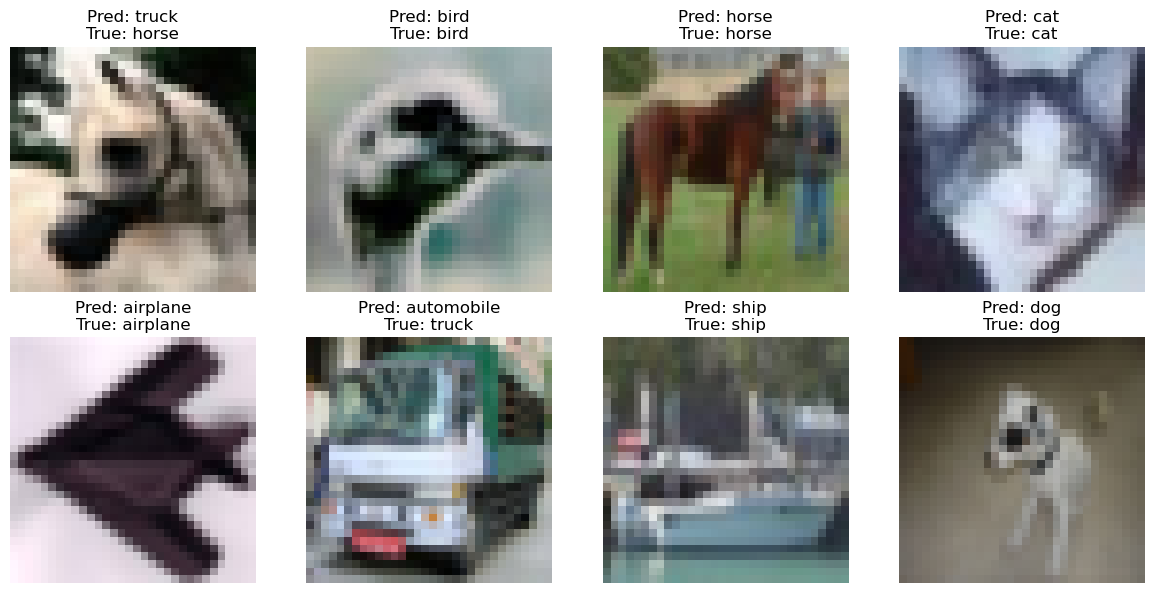

In [25]:
# Try to predict pictures 

# Pick N random images from the test set
num_images = 8
fig = plt.figure(figsize=(12, 6))
class_names = test_data.classes

for i in range(num_images):
    idx = torch.randint(0, len(test_data), size=(1,)).item()
    image, label = test_data[idx]
    
    # Prepare input tensor (batch of 1)
    input_tensor = image.unsqueeze(0).to(device)  # Shape: [1, 3, 32, 32]
    
    with torch.no_grad():
        output = best_model(input_tensor)
        pred_label = output.argmax(dim=1).item()

    # Plot
    fig.add_subplot(2, 4, i + 1)
    plt.imshow(image.permute(1, 2, 0))  # [C, H, W] → [H, W, C]
    plt.title(f"Pred: {class_names[pred_label]}\nTrue: {class_names[label]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


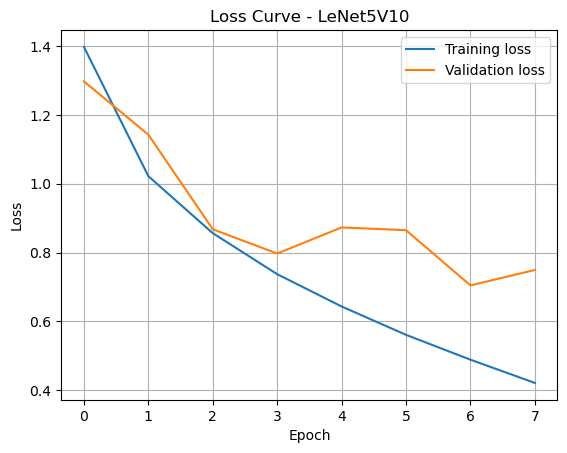

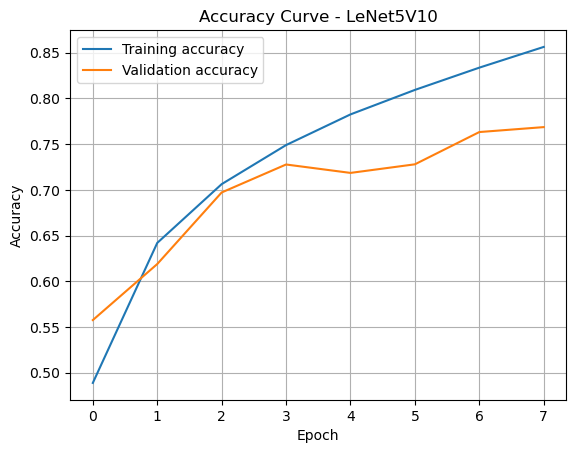

In [26]:
# Extract metrics for best model
best_metrics = metrics[overall_best_model_name]
train_losses = best_metrics["train_losses"]
valid_losses = best_metrics["valid_losses"]
train_accs = best_metrics["train_accuracies"]
valid_accs = best_metrics["valid_accuracies"]

# Plot losses
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.title(f"Loss Curve - {overall_best_model_name}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

# Plot accuracies
plt.plot(train_accs, label="Training accuracy")
plt.plot(valid_accs, label="Validation accuracy")
plt.title(f"Accuracy Curve - {overall_best_model_name}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

## Task 2.2: Report on your changes - 2.5 marks

**Task deliverables**:
- Write a brief report (max. 300 words), answering the following questions:
    - Why do you think the changes you made in Task 2.1 led to a higher test accuracy?
    - What else could you try to improve your model if you had more time and/or more computational resources?

## Answers for task 2.2:

Comapring the baseline model used in task 1, which is around 65% accuracy, the improved LetNet5 model achieved accuracy around 75%, which is a significant improvement. This performance boost results from serveral key changes made to the baseline model:
* Batch normalization stabilize the gradient flow, preventing vanishing or exploding gradients. It also acts as a regularizer, helping reduce overfitting.
* Replacing AvgPool with MaxPool improves feature selection by preserving only the most significant activations, such as edges and textures.
* Increasing the number of output channels provides more neurons for the model to learn complex patterns effectively.
* Adding an extra `nn.ReLU` and `nn.Linear` layer increases model capacity and enhances its ability to learn non-linear relationships.
* Dropout layers further improve generalization and reduce overfitting. Since BatchNorm is used, a lower dropout rate of 0.1 is applied.

Other potential improvements with more time/computational resources:
* Train for more epochs, due to limited computational resources only 8 epochs trained for each model.
* Reduce batch size may help improve generalization.
* Experiment with different activation functions, loss functions, and optimizers to find more optimal configurations.
* Try deeper neural networks with more convolutional blocks to increase model capacity.
* Test different combinations of hyperparameters in `Conv2d` and `MaxPool2d`, such as kernel size, stride, and padding.

